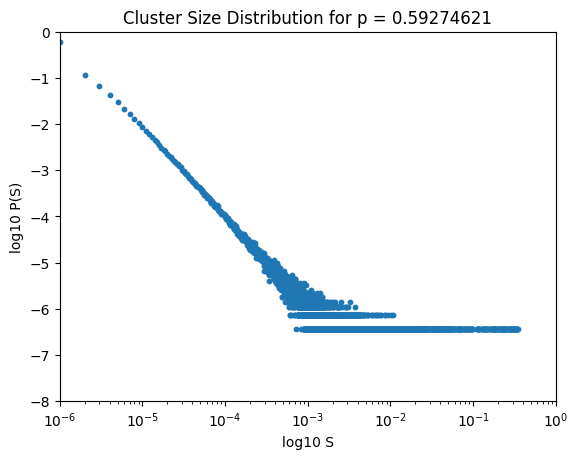

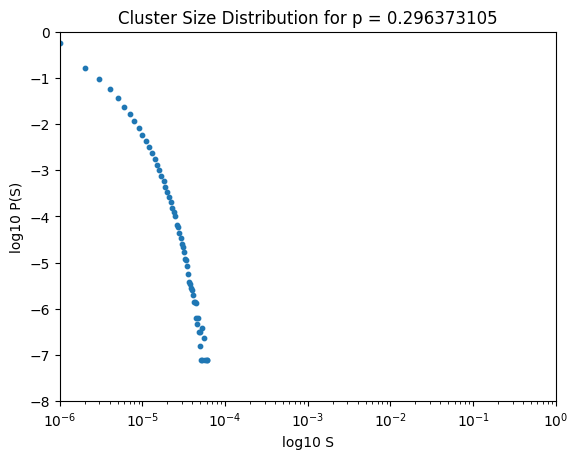

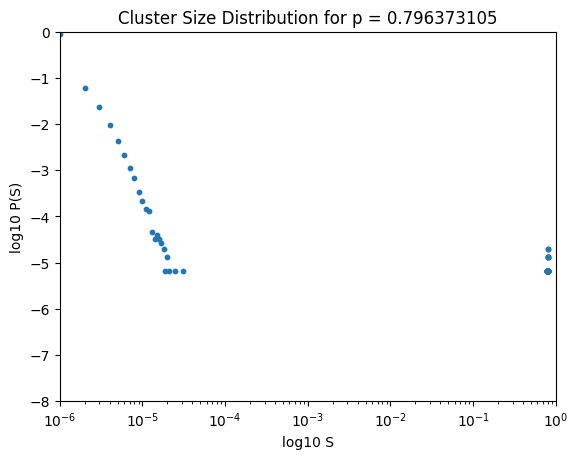

In [1]:
"""Percolation functions.

Notes:
- create `images/` (or change file paths below)
- cd to the directory containing this file and run `python3 percolation.py`
OR import and run in .ipynb
- add/change functions in line 96 to run what you want when calling the script
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage

##############################################
# adapted for POCs 1

L_VALUES = [20, 50, 100, 200, 500, 1000]  # square lattice of size L
# Pc for square lattices is a known/accepted quantity obtained from simulations
# Visually, we can see it is approx 0.59, and wikipedia says it is 0.59274621
# https://en.wikipedia.org/wiki/Percolation_theory
PERC_CRIT_PROB = 0.59274621  # p_c


def percolation_model(prob, L):
    """Run site percolation, return world as 2D array (the 'world')."""
    return np.random.choice([0, 1], size=(L, L), p=[1-prob, prob])


def get_perc_largest_cluster(prob, L, N_sim=0):
    if N_sim > 0:
        all_cluster_sizes = []

    # Run multiple simulations to get average cluster sizes
        for _ in range(N_sim):
            world = percolation_model(prob, L)
            structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
            label_world, nb_labels = ndimage.label(world, structure)
            cluster_sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
            all_cluster_sizes.extend(cluster_sizes)

        return np.max(all_cluster_sizes), all_cluster_sizes
    """Get the largest cluster in a percolation model."""
    world = percolation_model(prob, L)  # run model

    # filter largest cluster
    # Site percolation
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]  # define connection
    # label_world is array of same shape as world, with each elem (cluster) labeled
    # nb_labels is the number of labels/clusters
    label_world, nb_labels = ndimage.label(world, structure)
    # ndimage.sum sums values in world for each label in label_world
    # range(nb_labels + 1) says labels to sum over
    # cluster_sizes is array of elems, each is sum of values in world for that label
    cluster_sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
    return cluster_sizes.max(), cluster_sizes


# Parameters
def percolation_simulation():
    """Run entire percolation simulation."""
    probabilities = np.linspace(0, 1, 100)  # occupation probs (increments of 10^-2)

    # For each L, run N_tests for occupation prob
    for L in L_VALUES:
        print(f"L = {L}")
        prob_to_max_avg_cluster = []
        for p in probabilities:
            # run N_tests=100 of the percolation model
            # (a loop would be equivalent, but we're optimizing below
            max_cluster_sizes = [get_perc_largest_cluster(p, L)[0] for _ in range(100)]
            max_avg_cluster_size = np.mean(max_cluster_sizes)
            # fractional size: normalize the avg size by the total number of cells (L)
            prob_to_max_avg_cluster.append(max_avg_cluster_size / (L * L))
        plt.plot(probabilities, prob_to_max_avg_cluster, label=f"L = {L}")

    plt.axvline(PERC_CRIT_PROB, color="black", linestyle="--",
                label="Critical probability")
    plt.legend()
    plt.xlabel("Occupation probability")
    plt.ylabel("Fractional size of largest cluster")
    plt.savefig("images/h8_perc_sim_avg_vs_prob")
    print("Simulation complete and plot saved.")


def cluster_dist_plot(L=1000):
    dict_p_c_vals = {
        PERC_CRIT_PROB: 0,  # at critical probability
        PERC_CRIT_PROB / 2: 1,  # below critical
        PERC_CRIT_PROB + (1 - PERC_CRIT_PROB) / 2: 2  # above critical
    }
    total_sites = L * L  # Total number of sites in the lattice

    for p_c, label in dict_p_c_vals.items():
        _, all_cluster_sizes = get_perc_largest_cluster(p_c, L, N_sim=100)  # average over 100 simulations
        df = pd.DataFrame(all_cluster_sizes, columns=["clust_size"])
        dist = df['clust_size'].value_counts().sort_index()
        dist = dist.rename_axis('clust_size').reset_index(name='frequency')

        # Normalize the cluster sizes by total lattice area
        dist["clust_size"] = dist["clust_size"] / total_sites

        # Normalize the frequency by the total number of clusters
        total_clusters = dist["frequency"].sum()
        dist["log_frequency"] = dist["frequency"] / total_clusters  # Fraction of clusters
        dist["log_frequency"] = np.log10(dist["log_frequency"]) 

        plt.clf()
        plt.scatter(dist["clust_size"], dist["log_frequency"], marker="o", s=10)

        plt.xscale("log")

        plt.xlim([10**-6, 1]) 

        plt.ylim([-8, 0])

        plt.xlabel("log10 S")
        plt.ylabel("log10 P(S)")
        plt.title(f"Cluster Size Distribution for p = {p_c}")

        # plt.savefig(f"images/cluster_size_dist_{label}_{L}.png")
        plt.show()

# 3
# percolation_simulation()
# 4
cluster_dist_plot()


##############################################
# MOCS - stochastic cellular automata example (runable as is)

# def run_random_walker(world, position, history, steps):
#     """Run a random walker on a 2D world.
#
#       Note this does wrapping in the array--periodic boundary.
#     """
#     N1 = world.shape[0]
#     N2 = world.shape[1]
#     (i, j) = position
#     for k in range(steps):  # for every step
#         world[position] = 0.67
#         (i, j) = position
#         die = random.uniform(0, 1)
#         if die < 0.25:  # right step
#             position = (i, (j + 1) % N2)
#         elif die < 0.5:  # bottom step
#             position = ((i - 1) % N1, j)
#         elif die < 0.75:  # left step
#             position = (i, (j - 1) % N2)
#         else:  # top step
#             position = ((i + 1) % N1, j)
#         world[position] = 1
#         history.append(position)

#     return (world, position, history)


# def run_percolation(world, probability):
#     """Run stochastic site percolation on a 2D world."""
#     N1 = world.shape[0]
#     N2 = world.shape[1]
#     for i in range(N1):  # for cell in every row
#         for j in range(N2):  # and every column
#             die = random.uniform(0, 1)
#             if die < probability:
#                 world[(i, j)] = 1
#             else:
#                 world[(i, j)] = 0

#     return world


# Parameters
# N1, N2 = 512, 512  # height, width
# # occupation probability
# probability = 0.6  # @param {type:"slider", min:0, max:1, step:0.01}
# # initial conditions of zero
# world = np.zeros((N1, N2))

# world = run_percolation(world, probability)  # run model

# # Set up the figure
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
# ax1.set_ylim(0, N1)
# ax1.set_xlim(0, N2)
# ax2.set_ylim(0, N1)
# ax2.set_xlim(0, N2)
# ax1.set_aspect("equal")
# ax2.set_aspect("equal")

# # filter largest cluster
# structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]  # define connection
# label_world, nb_labels = ndimage.label(world, structure)  # label clusters
# sizes = ndimage.sum(world, label_world, range(nb_labels + 1))
# mask = sizes >= sizes.max()
# binary_img = mask[label_world]

# # Plot the world
# ax1.imshow((world), cmap=plt.get_cmap(cm.bone), origin="lower")
# ax2.imshow(binary_img, cmap=plt.get_cmap(cm.bone), origin="lower")

# # Add label
# ax1.text(2, N1 + 5, f"Site percolation with probability {probability}",
#         fontsize=18)
# ax2.text(2, N1 + 5, f"Largest cluster found", fontsize=18)
# plt.show()

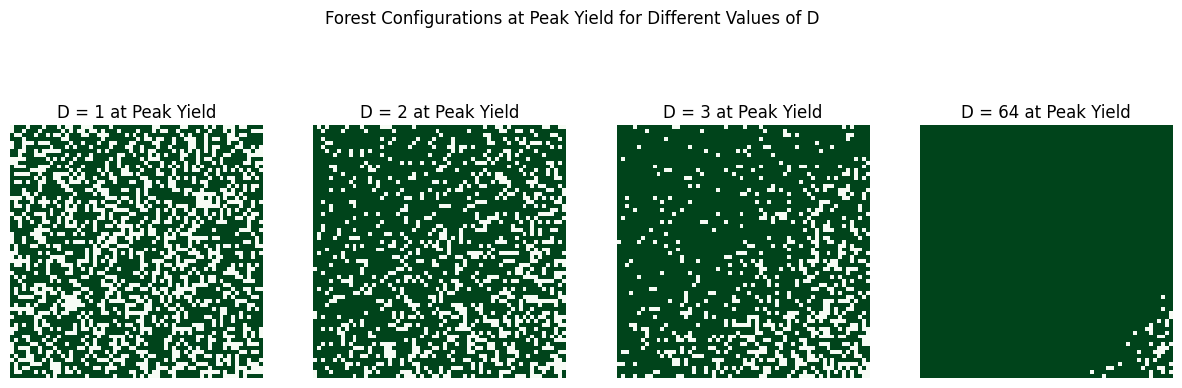

For D = 1: Peak Yield = 663.7717 at Density = 1.0000
For D = 2: Peak Yield = 2607.3813 at Density = 0.9995
For D = 3: Peak Yield = 3202.6302 at Density = 1.0000
For D = 64: Peak Yield = 4052.9999 at Density = 0.9995


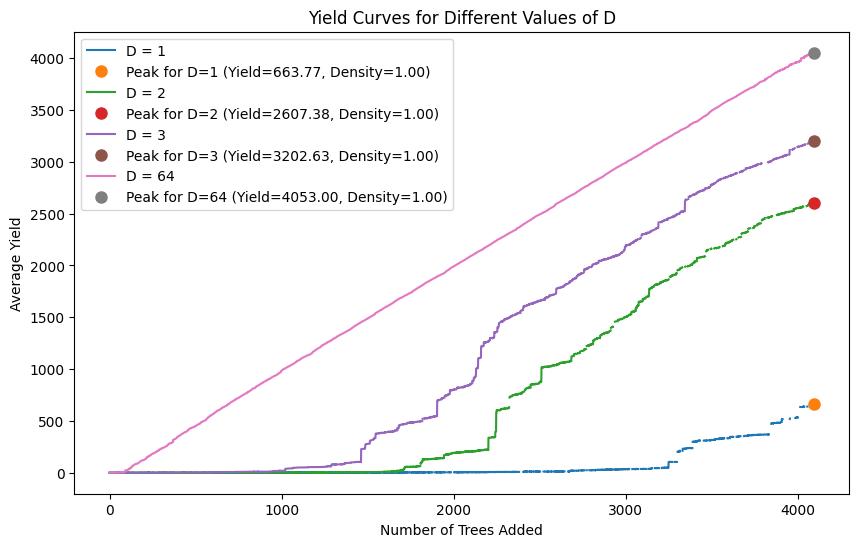

For D = 1: Peak yield configuration captured with 90 clusters.
For D = 2: Peak yield configuration captured with 23 clusters.
For D = 3: Peak yield configuration captured with 11 clusters.
For D = 64: Peak yield configuration captured with 1 clusters.


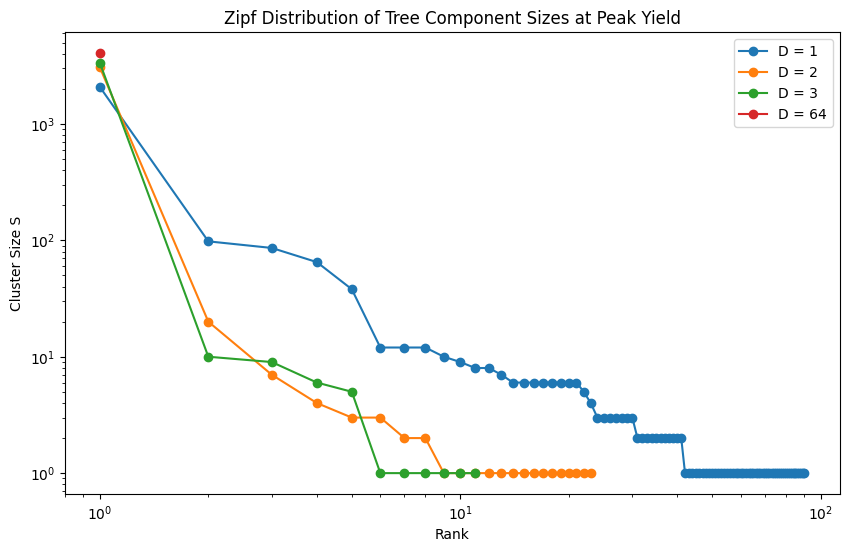

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Initialize spark distribution
def initialize_spark_distribution(L):
    ell = L / 10
    spark_distribution = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            spark_distribution[i, j] = np.exp(-i / ell) * np.exp(-j / ell)
    spark_distribution /= np.sum(spark_distribution)
    return spark_distribution

# Initialize empty forest
def initialize_forest(L):
    return np.zeros((L, L), dtype=int)

# Calculate fire yield based on spark distribution
def calculate_fire_yield(forest, spark_distribution):
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labeled_forest, num_clusters = label(forest, structure=structure)
    cluster_sizes = np.bincount(labeled_forest.ravel())[1:]
    component_size_map = np.zeros_like(forest)
    for cluster_id in range(1, num_clusters + 1):
        component_size_map[labeled_forest == cluster_id] = cluster_sizes[cluster_id - 1]
    expected_yield = np.sum(spark_distribution * component_size_map)
    return expected_yield

# Place tree based on best yield for each D
def place_tree(forest, spark_distribution, D):
    L = forest.shape[0]
    best_yield = -np.inf
    best_position = None
    for _ in range(D):
        i, j = np.random.randint(0, L, size=2)
        if forest[i, j] == 0:
            forest[i, j] = 1
            yield_if_planted = calculate_fire_yield(forest, spark_distribution)
            forest[i, j] = 0  # Reset tree after evaluation
            if yield_if_planted > best_yield:
                best_yield = yield_if_planted
                best_position = (i, j)
    if best_position:
        forest[best_position] = 1
    return best_yield

# Simulate forest growth and capture forest configuration at peak yield
def simulate_forest_growth(L, spark_distribution, D, max_trees):
    forest = initialize_forest(L)
    yields = []
    densities = []
    
    peak_yield = -np.inf
    peak_density = 0
    peak_index = 0
    peak_forest = None  # Initialize peak_forest to capture forest at peak yield
    
    for t in range(max_trees):
        current_yield = place_tree(forest, spark_distribution, D)
        current_density = (t + 1) / max_trees  # Calculate density
        
        # Track yields and densities
        yields.append(current_yield)
        densities.append(current_density)
        
        # Identify peak yield and corresponding density
        if current_yield > peak_yield:
            peak_yield = current_yield
            peak_density = current_density
            peak_index = t
            peak_forest = forest.copy()  # Capture the forest configuration at peak yield
    
    return yields, densities, peak_yield, peak_density, peak_index, peak_forest

# Analyze cluster sizes at peak yield
def analyze_cluster_sizes(forest):
    """Calculate component sizes and return them sorted."""
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labeled_forest, num_clusters = label(forest, structure=structure)
    cluster_sizes = np.bincount(labeled_forest.ravel())[1:]  # Skip background (label 0)
    cluster_sizes = cluster_sizes[cluster_sizes > 0]  # Filter out zero-sized clusters
    return np.sort(cluster_sizes)[::-1]  # Sort in descending order for Zipf plot

# Parameters
L = 64
D_values = [1, 2, 3, L]
max_trees = L * L
spark_distribution = initialize_spark_distribution(L)

#a
# # Run simulation and capture peak yield forest for each D
fig, axes = plt.subplots(1, len(D_values), figsize=(15, 5))
for idx, D in enumerate(D_values):
    if D > max_trees:  # Skip D if it exceeds the number of possible placements
        continue
    yields ,_, _, _, _, peak_forest = simulate_forest_growth(L, spark_distribution, D, max_trees)
    axes[idx].imshow(peak_forest, cmap='Greens', origin="upper")
    axes[idx].set_title(f"D = {D} at Peak Yield")
    axes[idx].axis("off")

# a
plt.suptitle("Forest Configurations at Peak Yield for Different Values of D")
plt.show()

#b
fig, ax = plt.subplots(figsize=(10, 6))

for D in D_values:
    yields, densities, peak_yield, peak_density, peak_index, _ = simulate_forest_growth(L, spark_distribution, D, max_trees)
    ax.plot(range(len(yields)), yields, label=f"D = {D}")
    ax.plot(peak_index, peak_yield, 'o', markersize=8, label=f"Peak for D={D} (Yield={peak_yield:.2f}, Density={peak_density:.2f})")

    print(f"For D = {D}: Peak Yield = {peak_yield:.4f} at Density = {peak_density:.4f}")

# Configure plot
ax.set_xlabel("Number of Trees Added")
ax.set_ylabel("Average Yield")
ax.set_title("Yield Curves for Different Values of D")
ax.legend()
plt.show()


# c Run simulation and plot Zipf distributions
fig, ax = plt.subplots(figsize=(10, 6))

for D in D_values:
    _, _, _, _, _, peak_forest = simulate_forest_growth(L, spark_distribution, D, max_trees)
    cluster_sizes = analyze_cluster_sizes(peak_forest)
    
    if len(cluster_sizes) == 0:
        print(f"No clusters found for D = {D}")
        continue
    
    # Plot Zipf (size) distribution
    ranks = np.arange(1, len(cluster_sizes) + 1)
    ax.plot(ranks, cluster_sizes, marker='o', label=f"D = {D}")
    print(f"For D = {D}: Peak yield configuration captured with {len(cluster_sizes)} clusters.")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Rank")
ax.set_ylabel("Cluster Size S")
ax.set_title("Zipf Distribution of Tree Component Sizes at Peak Yield")
ax.legend()
plt.show()

